In [1]:
import pathlib as pl
from configparser import ConfigParser
from math import factorial
import itertools as itt
from collections import defaultdict

import joblib as jl
import numpy as np
import scipy.stats as sst
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

from src.data.load import load
from src.visualization.interactive import plot_raw_pair, plot_pupil_so_effects
from src.root_path import config_path
from src.visualization.palette import *

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2022-08-09 181329.log


In [2]:
def plot_pupil_effect(cellid, contexts, probe):

    big = plot_raw_pair(cellid, contexts, probe, raster_fs=20, colors=TENCOLOR, pupil='big')['data']
    small = plot_raw_pair(cellid, contexts, probe, raster_fs=20, colors=TENCOLOR, pupil='small')['data']

    fig = make_subplots(rows=2, cols=2, shared_yaxes='rows', shared_xaxes=False,
                        subplot_titles=['big', 'small', 'raw pupil trace'],

                        specs=[[{}, {}],
                               [{'colspan':2},None]]

                        )

    # add psth traces to the suboplots
    _ = fig.add_traces(big, rows=[1]*len(big), cols=[1]*len(big))
    _ = fig.update_traces(showlegend=False)

    _ = fig.add_traces(small, rows=[1]*len(small), cols=[2]*len(small))

    # vertical lines of probe onset
    for cc in range(2):
        _ = fig.add_vline(x=0, line=dict(color='black',
                                     dash='dot'),
                      row=1, col=cc+1)

    # raw pupil trace
    recs, _ = load(cellid.split('-')[0], rasterfs=20, recache=False, pupil=True)
    pupil_trace = recs['perm0']['pupil']._data.squeeze(axis=0)
    t = np.linspace(0,pupil_trace.size/20, pupil_trace.size, endpoint=False)

    _ = fig.add_trace(go.Scatter(x=t, y=pupil_trace, mode='lines',
                                 line=dict(color='black'),
                                 showlegend=False),
                  row=2, col=1)

    _ = fig.add_hline(y=np.median(pupil_trace),
                      line=dict(color='gray',
                                dash='dot'),
                      row=2, col=1)

    fig.update_layout(margin=dict(l=10, r=10, t=50, b=10),)

    return fig

# new plan
1. find neurons with significant pupil first order effects, i.e. effects on firing rate (not on deltas or context stuff)
2. There is no need to do split the probe response by time, use full length
3. There is no need to keep track of contex information, aggregate by neuron and probe
4. plot the histograms for modulation coefficient for each site
5. the histogram can potentially aggregate by each neuron mean

## First order first

In [3]:
# New firing rates, the file is a misnomer, it has not deltas
fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220808_pupil_fr_by_instance'
first_ord_DF = jl.load(fr_DF_file
                ).query("part == 'probe' and chunk == 'full'"
                        # " and pupil != 'full'"
                        ).drop(columns=['chunk', 'part', 'metric']
                               ).reset_index(drop=True)
# reduces size with adecuate data  typing
m0 = first_ord_DF.memory_usage(deep=True).sum()

for col in ['id', 'site', 'pupil', 'probe', 'context']:
    first_ord_DF[col] = first_ord_DF[col].astype('category')

# for col in ['probe', 'context']:
#     first_ord_DF[col] = pd.to_numeric(first_ord_DF[col], downcast='unsigned')

first_ord_DF['value'] = pd.to_numeric(first_ord_DF['value'], downcast='float')

print(f"DF reduced to {first_ord_DF.memory_usage(deep=True).sum() / m0 *100:0.2f}% of original size!")
first_ord_DF = first_ord_DF.groupby(['id', 'site', 'probe', 'pupil'],
                                    observed=True, dropna=True).agg(value=('value',np.nanmean)).reset_index()

print(first_ord_DF.shape)
first_ord_DF.head()

DF reduced to 4.84% of original size!
(34344, 5)


,id,site,probe,pupil,value
0,ARM021b-02-2,ARM021b,1,small,-0.068843
1,ARM021b-02-2,ARM021b,1,big,0.203817
2,ARM021b-02-2,ARM021b,1,full,0.067487
3,ARM021b-02-2,ARM021b,2,small,-0.216955
4,ARM021b-02-2,ARM021b,2,big,-0.151314


In [4]:
pivoted_fo = first_ord_DF.pivot_table(index=['id','site','probe',],
                                   columns='pupil', values='value',
                                   dropna=True, observed=True).reset_index().copy()
pivoted_fo['mod_coeff'] = (pivoted_fo['big'] - pivoted_fo['small']) /  (pivoted_fo['big'] + pivoted_fo['small'])
pivoted_fo['mod_coeff_corrected'] = (pivoted_fo['big'] - pivoted_fo['small']) /\
                                    (np.abs(pivoted_fo['big']) + np.abs(pivoted_fo['small']))

pivoted_fo['abs_mod_coeff'] = np.abs(pivoted_fo['mod_coeff'])
pivoted_fo['abs_mod_coeff_corrected'] = np.abs(pivoted_fo['mod_coeff_corrected'])

pivoted_fo.head()

pupil,id,site,probe,big,full,small,mod_coeff,mod_coeff_corrected,abs_mod_coeff,abs_mod_coeff_corrected
0,ARM021b-02-2,ARM021b,1,0.203817,0.067487,-0.068843,2.020093,1.000000,2.020093,1.000000
1,ARM021b-02-2,ARM021b,2,-0.151314,-0.184134,-0.216955,-0.178240,0.178240,0.178240,0.178240
2,ARM021b-02-2,ARM021b,3,-0.176560,-0.200965,-0.225370,-0.121438,0.121438,0.121438,0.121438
3,ARM021b-02-2,ARM021b,4,0.767651,0.695278,0.622905,0.104092,0.104092,0.104092,0.104092
4,ARM021b-04-3,ARM021b,1,0.343856,0.343856,0.343856,0.000000,0.000000,0.000000,0.000000


In [5]:

panels = defaultdict(list)

first order effects for full duraiont:
WilcoxonResult(statistic=758857.5, pvalue=1.6587728219247458e-68)


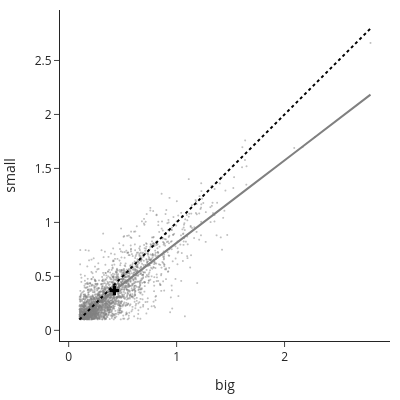

In [6]:
panelname = "first_order_scatter"
toplot = pivoted_fo.query(f"(big > 0.1 and small > 0.1)").copy()

# main scatter
fig = px.scatter(data_frame=toplot, x='big',y='small',
                 hover_name='id', hover_data=['probe'],
                 trendline='ols',
                 render_mode='svg'
                 )

fig.update_traces(marker=dict(color='gray',
                              size=2,opacity=0.5),
                  line=dict(color='gray',
                            width=2,
                            dash='solid')
                  )



interval = [np.min([toplot.big.min(),toplot.small.min()]),
            np.max([toplot.big.max(),toplot.small.max()])]

fig.add_trace(go.Scatter(x=interval, y=interval, mode='lines',
                         line=dict(color='black', dash='dot'),
                         showlegend=False))

# mean marker
fig.add_trace(go.Scatter(x=[toplot.big.mean()], y=[toplot.small.mean()], mode='markers',
                         marker=dict(color='black',
                                     size=8,
                                     symbol='cross'),
                         showlegend=False))

if panelname in panels.keys():
    panels.pop(panelname)

panels[panelname].extend(fig['data'])

fig.update_layout(template='simple_white',
                  margin=dict(l=10, r=10, t=10, b=10),
                  xaxis=dict(scaleanchor='y',
                             constrain='domain'))

print(f"first order effects for full duraiont:"
      f"\n{sst.wilcoxon(toplot.big, toplot.small)}")

img_bytes = fig.to_image(format="png", width=400, height=400)
Image(img_bytes)
# fig.show()

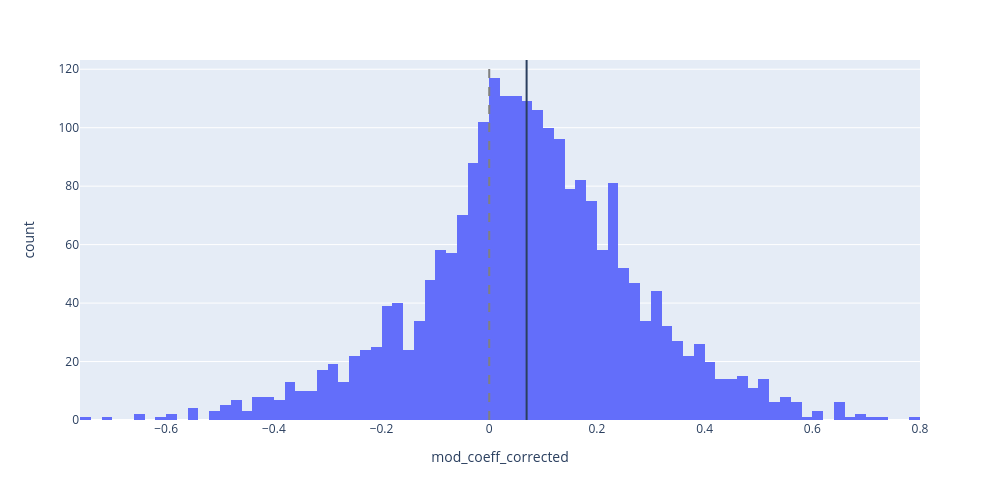

In [7]:
toplot = pivoted_fo.query(f"(big > 0.1 and small > 0.1)")


fig = px.histogram(toplot, x='mod_coeff')
fig = px.histogram(toplot, x='mod_coeff_corrected')
fig.add_vline(x=toplot.mod_coeff_corrected.mean())
fig.add_vline(x=0, line_color='gray', line_dash='dash')

img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

# Second order effects

having found a handful of neurons that are worth looking at, now try to determine the effect of these big pupil
changes in the contextual modulation.
1. get second order data i.e. delta FR as a funcion of pupil size
2. taking care of flippign delta FR so all are possitive for the pupil independent fr
3. properly casting the data types to save e on memory
4. filter by signiricant instancese
5. order by first order effects
6. plotting only the best examples

In [8]:
# New firing rates, the file is a misnomer, it has not deltas
# fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220801_pupil_delta_firerates'
fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220808_pupil_fr_by_instance'
second_ord_DF = jl.load(fr_DF_file
                ).query("part == 'probe'"
                        ).drop(columns=['part', 'metric']
                               ).reset_index(drop=True)

m0 = second_ord_DF.memory_usage(deep=True).sum()

for col in ['id', 'site', 'pupil', 'probe', 'context', 'chunk']:
    second_ord_DF[col] = second_ord_DF[col].astype('category')

second_ord_DF['value'] = pd.to_numeric(second_ord_DF['value'], downcast='float')

print(f"DF reduced to {second_ord_DF.memory_usage(deep=True).sum() / m0 *100:0.2f}% of original size!")

print(second_ord_DF.shape)
second_ord_DF.head()


# Calculate delta firing rate for pairs of contexts
second_ord_DF = second_ord_DF.pivot_table(index=['id', 'site', 'chunk', 'probe', 'pupil'], columns=['context'],
                                   values='value', aggfunc='first', dropna=True, observed=True)

n_comb = int(factorial(second_ord_DF.shape[1]) /
             (2 * factorial(second_ord_DF.shape[1] - 2)))
ctx_pair_R = np.full((second_ord_DF.shape[0], n_comb), np.nan)
new_cols = list()
for pr_idx, (c0, c1) in enumerate(itt.combinations(second_ord_DF.columns, r=2)):
    new_cols.append(f'{c0:02}_{c1:02}')
    ctx_pair_R[:, pr_idx] = second_ord_DF.values[:, c0] - second_ord_DF.values[:, c1]

# Melts back into long format and ensures column typing for memory efficiency
second_ord_DF = pd.DataFrame(index=second_ord_DF.index, columns=new_cols, data=ctx_pair_R
                      ).melt(var_name='context_pair', value_name='delta_fr', ignore_index=False).dropna().reset_index()
second_ord_DF['context_pair'] = second_ord_DF['context_pair'].astype('category')

print(second_ord_DF.memory_usage(deep=True))
print(second_ord_DF.dtypes)
print(second_ord_DF.shape)
second_ord_DF.head()

DF reduced to 4.01% of original size!
(1624050, 7)
Index                128
id              15085136
site             7460580
chunk            7455165
probe            7455080
pupil            7454991
context_pair     7460214
delta_fr        59637600
dtype: int64
id              category
site            category
chunk           category
probe           category
pupil           category
context_pair    category
delta_fr         float64
dtype: object
(7454700, 7)


,id,site,chunk,probe,pupil,context_pair,delta_fr
0,ARM021b-02-2,ARM021b,A,1,small,00_01,-0.134647
1,ARM021b-02-2,ARM021b,A,1,big,00_01,-0.201970
2,ARM021b-02-2,ARM021b,A,1,full,00_01,-0.168309
3,ARM021b-02-2,ARM021b,A,2,small,00_01,0.168309
4,ARM021b-02-2,ARM021b,A,2,big,00_01,0.100985


In [9]:
pivoted_so = second_ord_DF.pivot_table(index=['id', 'site', 'context_pair', 'probe', 'chunk'],
                                   columns='pupil', values='delta_fr', aggfunc='first',
                                   dropna=True, observed=True).reset_index()

# flips firing rates
flipper = (pivoted_so.full.values > 0) * 2 - 1
pivoted_so['small_flipped'] = pivoted_so['small'] * flipper
pivoted_so['big_flipped'] = pivoted_so['big'] * flipper
pivoted_so['full_flipped'] = pivoted_so['full'] * flipper
del(flipper)

pivoted_so['mod_coeff'] = (pivoted_so['big_flipped'] - pivoted_so['small_flipped']) /\
                          (pivoted_so['big_flipped'] + pivoted_so['small_flipped'])

pivoted_so['mod_coeff_corrected'] = (pivoted_so['big_flipped'] - pivoted_so['small_flipped']) /\
                          (np.abs(pivoted_so['big_flipped']) + np.abs(pivoted_so['small_flipped']))


pivoted_so['abs_mod_coeff'] = np.abs(pivoted_so['mod_coeff'])
pivoted_so['abs_mod_coeff_corrected'] = np.abs(pivoted_so['mod_coeff_corrected'])

# some instances of zero FR and no difference between pupils leads to nan and inf mod_coeff, removes those rows
pivoted_so.replace([-np.inf, np.inf], np.nan, inplace=True)
pivoted_so.dropna(axis='index', inplace=True)

print(pivoted_so.shape)
pivoted_so.head()

(2355099, 15)


pupil,id,site,context_pair,probe,chunk,big,full,small,small_flipped,big_flipped,full_flipped,mod_coeff,mod_coeff_corrected,abs_mod_coeff,abs_mod_coeff_corrected
0,ARM021b-02-2,ARM021b,00_01,1,A,-0.201970,-0.168309,-0.134647,0.134647,0.201970,0.168309,0.200000,0.200000,0.200000,0.200000
1,ARM021b-02-2,ARM021b,00_01,1,B,-0.168309,-0.117816,-0.067323,0.067323,0.168309,0.117816,0.428571,0.428571,0.428571,0.428571
2,ARM021b-02-2,ARM021b,00_01,1,C,0.235632,0.084154,-0.067323,-0.067323,0.235632,0.084154,1.800000,1.000000,1.800000,1.000000
3,ARM021b-02-2,ARM021b,00_01,1,D,0.000000,-0.067323,-0.134647,0.134647,-0.000000,0.067323,-1.000000,-1.000000,1.000000,1.000000
4,ARM021b-02-2,ARM021b,00_01,1,full,-0.033662,-0.067323,-0.100985,0.100985,0.033662,0.067323,-0.500000,-0.500000,0.500000,0.500000


In [10]:
test = pivoted_so['full'] - (((pivoted_so['big'] + pivoted_so['small']))/2)
test

0          0.000000e+00
1          7.450581e-09
2          0.000000e+00
3          1.490116e-08
4         -3.725290e-09
               ...     
2484895    1.117587e-08
2484896   -7.450581e-09
2484897    3.725290e-09
2484898    7.450581e-09
2484899    7.450581e-09
Length: 2355099, dtype: float64

### filter for contextual significance

In [11]:
 # Cluster Mass significant contextual effects
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220719_chunked_amplitude_DF'

metrics = ['integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D',]
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and "
                                    f"value > 0 and value < 10000")

DF['chunk'] = DF['metric'].str.split('_').str[-1]
DF.loc[:,'chunk'].replace({'integral': 'full'}, inplace=True)

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'metric', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)

for col in ['id','context_pair','probe','site', 'region', 'chunk']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
DF.head()

,id,context_pair,probe,value,site,region,chunk
0,AMT029a-35-1,00_01,1,540.689758,AMT029a,PEG,full
1,AMT029a-43-1,00_01,1,542.716431,AMT029a,PEG,full
2,AMT029a-48-1,00_01,1,432.214355,AMT029a,PEG,full
3,AMT029a-51-1,00_01,1,358.975830,AMT029a,PEG,full
4,AMT029a-57-1,00_01,1,336.460602,AMT029a,PEG,full


#### merge tables of first, second order and signif contextual effects

In [12]:
full_merge = pd.merge(pivoted_fo, pivoted_so, on=['id', 'site', 'probe'], suffixes=('_fo', '_so'), validate='1:m')

full_merge = pd.merge(full_merge, DF, on=['id','site','context_pair', 'probe', 'chunk',], validate='m:1')
full_merge.rename(columns={'value': 'T-score_integral'}, inplace=True)
print(full_merge.shape)
full_merge.head()

(105922, 24)


,id,site,probe,big_fo,full_fo,small_fo,mod_coeff_fo,mod_coeff_corrected_fo,abs_mod_coeff_fo,abs_mod_coeff_corrected_fo,...,small_so,small_flipped,big_flipped,full_flipped,mod_coeff_so,mod_coeff_corrected_so,abs_mod_coeff_so,abs_mod_coeff_corrected_so,T-score_integral,region
0,ARM021b-02-2,ARM021b,1,0.203817,0.067487,-0.068843,2.020093,1.0,2.020093,1.0,...,-1.279145,1.279145,1.279145,1.279145,0.000000,0.000000,0.000000,0.000000,815.969238,PEG
1,ARM021b-02-2,ARM021b,1,0.203817,0.067487,-0.068843,2.020093,1.0,2.020093,1.0,...,-0.639573,0.639573,0.841543,0.740558,0.136364,0.136364,0.136364,0.136364,118.634201,PEG
2,ARM021b-02-2,ARM021b,1,0.203817,0.067487,-0.068843,2.020093,1.0,2.020093,1.0,...,-0.572249,0.572249,0.698481,0.635365,0.099338,0.099338,0.099338,0.099338,934.603455,PEG
3,ARM021b-02-2,ARM021b,1,0.203817,0.067487,-0.068843,2.020093,1.0,2.020093,1.0,...,-1.144498,1.144498,1.077175,1.110837,-0.030303,-0.030303,0.030303,0.030303,661.464905,PEG
4,ARM021b-02-2,ARM021b,1,0.203817,0.067487,-0.068843,2.020093,1.0,2.020093,1.0,...,-0.471264,0.471264,0.664819,0.568041,0.170370,0.170370,0.170370,0.170370,661.464905,PEG


### First and second order effects
There is no clear relationship between them, even with the possible flip of sign
of Second order effects, I woudl expect a C shaped graph

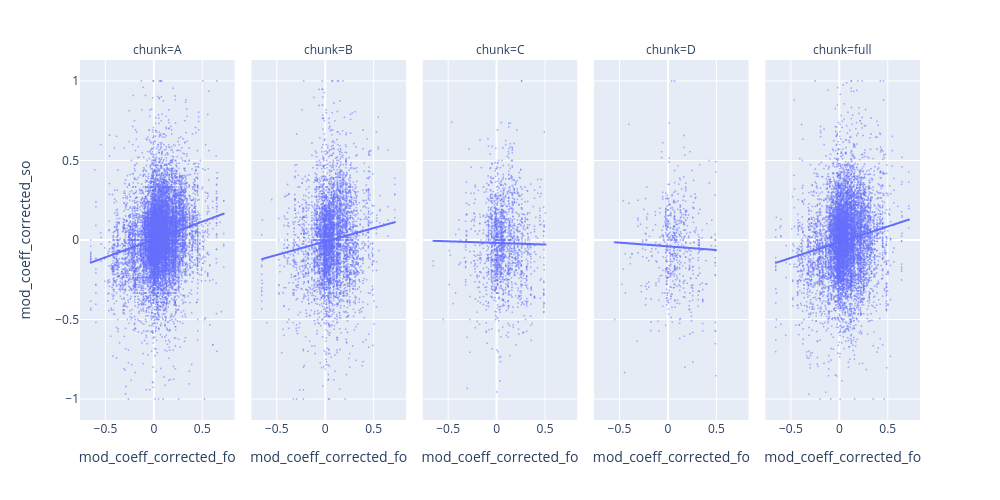

In [13]:
# relate first order  to second order pupil effects

# toplot = full_merge.query(f"small_fo < -0.1  and big_fo < -0.1"
#                           f" and ((full_so <= -0.3) or (0.3 <= full_so))"
#                           ).copy()

toplot = full_merge.query(f"small_fo > 0.1  and big_fo > 0.1"
                          f" and ((full_so <= -0.3) or (0.3 <= full_so))"
                          )

fig = px.scatter(toplot, x='mod_coeff_corrected_fo', y='mod_coeff_corrected_so', facet_col='chunk',
                 trendline='ols',
                 category_orders={'chunk':['A','B','C','D','full']})
fig.update_traces(marker=dict(size=2,opacity=0.5))

img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

In [14]:
# the p values from the regression support the idea that this effect is only significant on chunks A and B.
for chnk in ['A','B','C','D','full']:
    toreg = toplot.query(f"chunk == '{chnk}'")
    x = toreg.mod_coeff_corrected_fo
    y = toreg.mod_coeff_corrected_so
    print(f'\n{chnk}: {sst.linregress(x,y)}')


A: LinregressResult(slope=0.22442897355509717, intercept=0.003345377861169334, rvalue=0.17937610298567747, pvalue=5.59745163413381e-93, stderr=0.010882867833592538, intercept_stderr=0.0019257639993013908)

B: LinregressResult(slope=0.16904783845366522, intercept=-0.010092610195442492, rvalue=0.11226520270241515, pvalue=2.6839578721566798e-15, stderr=0.02131665090966638, intercept_stderr=0.00380045511420632)

C: LinregressResult(slope=-0.020166369201153233, intercept=-0.018393301799718684, rvalue=-0.013476906755829679, pvalue=0.5667569617845274, stderr=0.03519807972447311, intercept_stderr=0.006116533371063497)

D: LinregressResult(slope=-0.0462987810282284, intercept=-0.03970150778751231, rvalue=-0.03278371994080156, pvalue=0.3986416627565601, stderr=0.05481773061057862, intercept_stderr=0.010377758909123676)

full: LinregressResult(slope=0.1977069665527733, intercept=-0.014761478174833444, rvalue=0.1445699011754332, pvalue=4.184360519688565e-43, stderr=0.014287666061758946, intercept

first vs second order modulation index:
LinregressResult(slope=0.1977069665527733, intercept=-0.014761478174833444, rvalue=0.1445699011754332, pvalue=4.184360519688565e-43, stderr=0.014287666061758946, intercept_stderr=0.0025258584139075664)


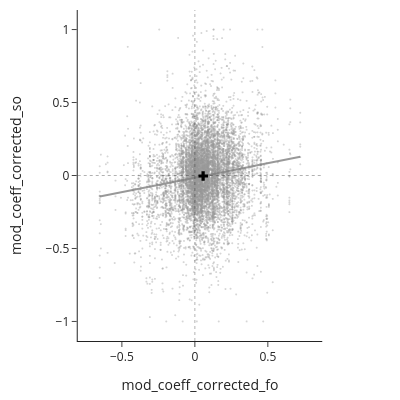

In [15]:
panelname = "first_vs_second_order"
toplot = full_merge.query(f"small_fo > 0.1  and big_fo > 0.1"
                          f" and ((full_so <= -0.3) or (0.3 <= full_so))"
                          f" and chunk == 'full'"
                          ).copy()

xstr = 'mod_coeff_corrected_fo'
ystr = 'mod_coeff_corrected_so'

# main scatter
fig = px.scatter(data_frame=toplot,
                 x=xstr, y=ystr,
                 hover_name='id', hover_data=['probe'],
                 trendline='ols',
                 render_mode='svg',
                 )

fig.update_traces(marker=dict(color='gray',
                              size=2,opacity=0.4),
                  line=dict(color='gray',
                            width=2,
                            dash='solid'),
                  opacity=0.8
                  )

# interval = [np.min([toplot[xstr].min(),toplot[ystr].min()]),
#             np.max([toplot[xstr].max(),toplot[ystr].max()])]
#
# fig.add_trace(go.Scatter(x=interval, y=interval, mode='lines',
#                          line=dict(color='black', dash='dot'),
#                          showlegend=False))

# mean marker
fig.add_trace(go.Scatter(x=[toplot[xstr].mean()],
                         y=[toplot[ystr].mean()],
                         mode='markers',
                         marker=dict(color='black',
                                     size=8,
                                     symbol='cross'),
                         showlegend=False))

if panelname in panels.keys():
    panels.pop(panelname)

panels[panelname].extend(fig['data'])

fig.add_vline(x=0,line=dict(color='black', dash='dot', width=1))
fig.add_hline(y=0,line=dict(color='black', dash='dot', width=1))

fig.update_layout(template='simple_white',
                  margin=dict(l=10, r=10, t=10, b=10),
                  xaxis=dict(scaleanchor='y',
                             constrain='domain'))

print(f"first vs second order modulation index:"
      f"\n{sst.linregress(toplot[xstr], toplot[ystr])}")

img_bytes = fig.to_image(format="png", width=400, height=400)
Image(img_bytes)
# fig.show()

# Format a quick figure
since the slope is non significant on late stages, focuses on the correlation for the full lenght of the probe response
plots a formated version of this scatter, alongside a couple of examples


### relate contextual modulation to second order effects

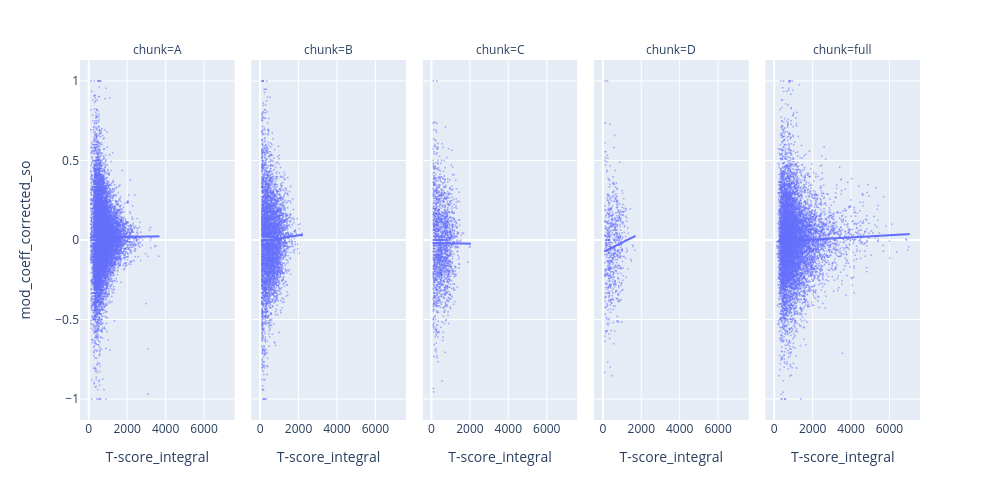

In [16]:
toplot = full_merge.query(f"small_fo > 0.1  and big_fo > 0.1"
                          f" and ((full_so <= -0.3) or (0.3 <= full_so))"
                          )

fig = px.scatter(toplot, x='T-score_integral', y='mod_coeff_corrected_so', facet_col='chunk',
                 trendline='ols',
                 category_orders={'chunk':['A','B','C','D','full']})

fig.update_traces(marker=dict(size=2,opacity=0.5))

img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

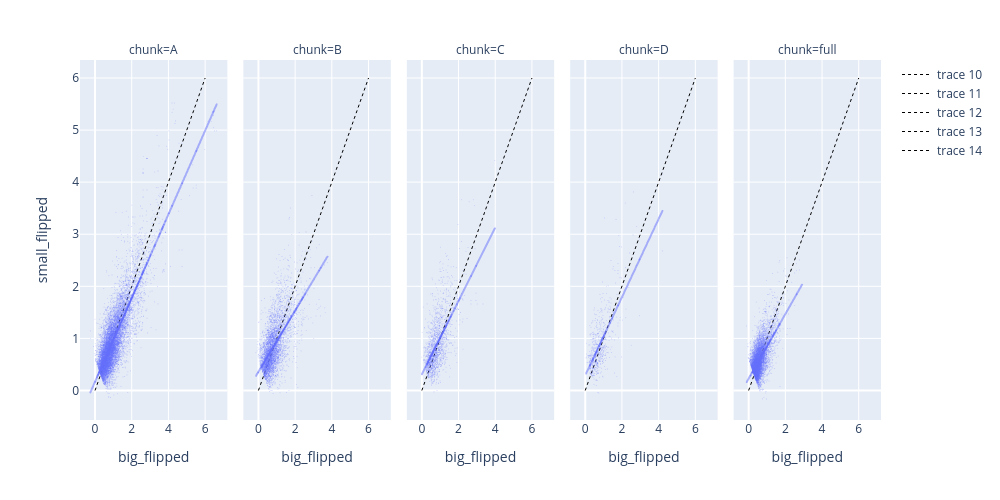

In [17]:
toplot = full_merge.query(f"small_fo > 0.1  and big_fo > 0.1"
                          f" and ((full_so <= -0.3) or (0.3 <= full_so))"
                          )

fig = px.scatter(toplot, x='big_flipped', y='small_flipped', facet_col='chunk',
                 trendline='ols',
                 category_orders={'chunk':['A','B','C','D','full']})

fig.update_traces(marker=dict(size=1,
                              opacity=0.5,
                              ),
                  opacity=0.5)

for col in range(5):
    interval = [0,6] # hardcoded cause im lazy
    fig.add_trace(go.Scatter(x=interval, y=interval, mode='lines',
                             line=dict(color='black',
                                       dash='dot',
                                       width=1)),
                  col=col+1, row=1)



img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

In [18]:
for chnk in ['A', 'B', 'C', 'D', 'full']:
    toreg = toplot.query(f"chunk == '{chnk}'")
    wkx = sst.wilcoxon(toreg.big_flipped, toreg.small_flipped)
    print(f'\nchunk {chnk}: big={toreg.big_flipped.mean()}, small={toreg.small_flipped.mean()} '
          f'delta={toreg.big_flipped.mean()-toreg.small_flipped.mean()}')
    print(wkx)


chunk A: big=0.992211172927613, small=0.9615750582863972 delta=0.03063611464121574
WilcoxonResult(statistic=35137357.0, pvalue=4.47690084927122e-21)

chunk B: big=0.8632602795919218, small=0.8519559151234721 delta=0.011304364468449624
WilcoxonResult(statistic=5780807.5, pvalue=0.5209244411776315)

chunk C: big=0.8501456122723912, small=0.8982503970867696 delta=-0.04810478481437841
WilcoxonResult(statistic=680845.0, pvalue=8.768694247373175e-06)

chunk D: big=0.8170009724291644, small=0.89190329500383 delta=-0.07490232257466567
WilcoxonResult(statistic=82484.5, pvalue=2.0158024344102862e-06)

chunk full: big=0.576834704238644, small=0.5788092720984576 delta=-0.0019745678598135363
WilcoxonResult(statistic=19564665.5, pvalue=0.24117001367016255)


second order big vs small pupil:
WilcoxonResult(statistic=35137357.0, pvalue=4.47690084927122e-21)


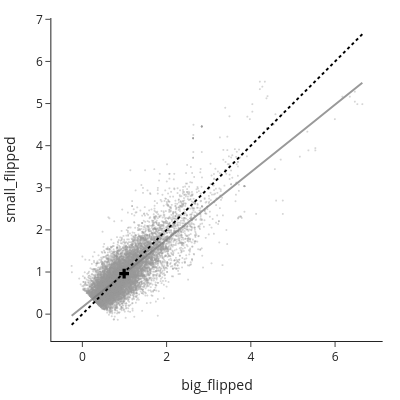

In [53]:
panelname = "second_order_scatte"

toplot = full_merge.query(f"small_fo > 0.1  and big_fo > 0.1"
                          f" and ((full_so <= -0.3) or (0.3 <= full_so))"
                          f" and chunk == 'A'"
                          ).copy()

xstr = 'big_flipped'
ystr = 'small_flipped'

# main scatter
fig = px.scatter(data_frame=toplot,
                 x=xstr, y=ystr,
                 hover_name='id', hover_data=['probe'],
                 trendline='ols',
                 render_mode='svg'
                 )

fig.update_traces(marker=dict(color='gray',
                              size=2,opacity=0.4),
                  line=dict(color='gray',
                            width=2,
                            dash='solid'),
                  opacity=0.8
                  )

interval = [np.min([toplot[xstr].min(),toplot[ystr].min()]),
            np.max([toplot[xstr].max(),toplot[ystr].max()])]

fig.add_trace(go.Scatter(x=interval, y=interval, mode='lines',
                         line=dict(color='black', dash='dot'),
                         showlegend=False))

# mean marker
fig.add_trace(go.Scatter(x=[toplot[xstr].mean()],
                         y=[toplot[ystr].mean()],
                         mode='markers',
                         marker=dict(color='black',
                                     size=8,
                                     symbol='cross'),
                         showlegend=False))

if panelname in panels.keys():
    panels.pop(panelname)

panels[panelname].extend(fig['data'])

# fig.add_vline(x=0,line=dict(color='black', dash='dot', width=1))
# fig.add_hline(y=0,line=dict(color='black', dash='dot', width=1))

fig.update_layout(template='simple_white',
                  margin=dict(l=10, r=10, t=10, b=10),
                  xaxis=dict(scaleanchor='y',
                             constrain='domain'))

print(f"second order big vs small pupil:"
      f"\n{sst.wilcoxon(toplot[xstr], toplot[ystr])}")

img_bytes = fig.to_image(format="png", width=400, height=400)
Image(img_bytes)
# fig.show()

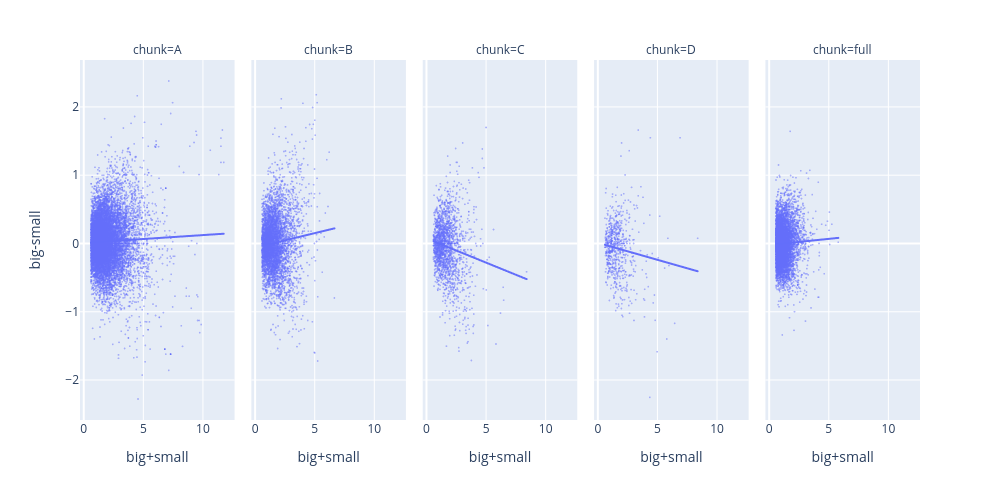

In [20]:
toplot = full_merge.query(f"small_fo > 0.1  and big_fo > 0.1"
                          f" and ((full_so <= -0.3) or (0.3 <= full_so))"
                          ).copy()

toplot['big+small'] = toplot['big_flipped'] + toplot['small_flipped']
toplot['big-small'] = toplot['big_flipped'] - toplot['small_flipped']

fig = px.scatter(toplot, x='big+small', y='big-small', facet_col='chunk',
                 trendline='ols',
                 category_orders={'chunk':['A','B','C','D','full']})
fig.update_traces(marker=dict(size=2,opacity=0.5))

img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

In [21]:
for chnk in ['A','B','C','D','full']:
    toreg = toplot.query(f"chunk == '{chnk}'")
    x = toreg['big+small']
    y = toreg['big-small']
    print(f'\n{chnk}: {sst.linregress(x,y)}')


A: LinregressResult(slope=0.011442825334544646, intercept=0.008279280056395562, rvalue=0.03619069178869196, pvalue=4.2309708270212564e-05, stderr=0.0027937179626233467, intercept_stderr=0.0063032624474957675)

B: LinregressResult(slope=0.04219716324307271, intercept=-0.06107289329711784, rvalue=0.08811395405087832, pvalue=5.766347715660629e-10, stderr=0.006796021738266455, intercept_stderr=0.012981174647522705)

C: LinregressResult(slope=-0.07101644044317455, intercept=0.07606007625536057, rvalue=-0.1470779687031584, pvalue=3.2689157254604937e-10, stderr=0.01123526541720767, intercept_stderr=0.021797061918033614)

D: LinregressResult(slope=-0.04976005292931654, intercept=0.01013284422393504, rvalue=-0.11534976141250516, pvalue=0.0028924198637890327, stderr=0.016641739046756924, intercept_stderr=0.032415021931433134)

full: LinregressResult(slope=0.017891903586722126, intercept=-0.02265123846501312, rvalue=0.03796486500339375, pvalue=0.0003220916704857298, stderr=0.004972390876968115, 

### Example PSTHs

In [22]:
# first find an example, the following conditions have to be met
# possitive big first order effects (on full duration)
# possitive big second order effectse (on chunk A)
# big contextual effecs

tosort = full_merge.query("small_fo > 0.1  and big_fo > 0.1"
                          " and ((full_so <= -0.3) or (0.3 <= full_so))"
                          " and mod_coeff_corrected_fo > 0"
                          " and mod_coeff_corrected_so > 0"
                          " and chunk == 'A'").loc[:, ['id', 'context_pair', 'probe',
                                                        'mod_coeff_corrected_fo', 'mod_coeff_corrected_so',
                                                        'T-score_integral']].copy()
tosort['ctx_mod_norm'] = tosort['T-score_integral'] / tosort['T-score_integral'].max()
tosort['euc_dist'] = np.linalg.norm(tosort.loc[:,
                                    ['mod_coeff_corrected_fo',
                                     'mod_coeff_corrected_so',
                                     'ctx_mod_norm']].values,
                                    axis=1)

tosort.sort_values(by='euc_dist', ascending=False, inplace=True, ignore_index=True)

tosort

,id,context_pair,probe,mod_coeff_corrected_fo,mod_coeff_corrected_so,T-score_integral,ctx_mod_norm,euc_dist
0,ARM031a-52-6,03_04,2,0.651578,1.000000,480.035950,0.148092,1.202699
1,TNC019a-031-2,00_08,9,0.506281,1.000000,481.777008,0.148629,1.130668
2,ARM031a-38-3,01_03,3,0.568314,0.935484,143.865097,0.044383,1.095482
3,TNC019a-040-3,00_03,10,0.055810,1.000000,633.486389,0.195432,1.020445
4,TNC014a-22-2,00_10,7,0.071783,1.000000,580.850647,0.179194,1.018461
...,...,...,...,...,...,...,...,...
4855,ARM024a-48-4,01_03,1,0.020254,0.052632,174.673843,0.053887,0.078001
4856,TNC023a-20-1,08_09,1,0.005432,0.052632,184.197098,0.056825,0.077645
4857,TNC014a-22-2,01_05,8,0.009915,0.028571,148.531509,0.045822,0.054903
4858,TNC008a-15-1,00_07,6,0.015027,0.023256,142.678467,0.044017,0.052001


[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/ARM031a_bd159d6778e641492008d59a4998680b86f1908e.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Armillaria/ARM031/ARM031a10_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Armillaria/ARM031/ARM031a10_p_CPN.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Armillaria/ARM031/ARM031a11_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Armillaria/ARM031/ARM031a11_p_CPN.evp


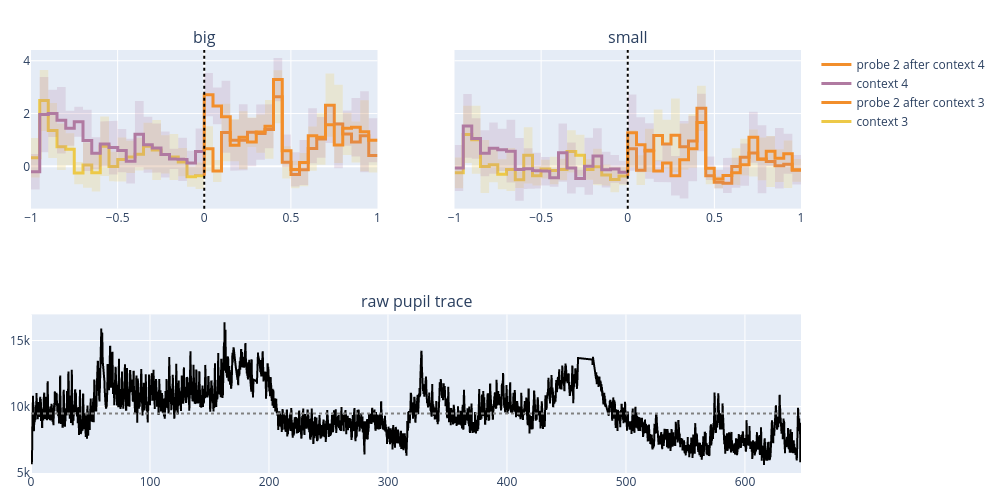

In [23]:
ii = 0
cellid = tosort.loc[ii,'id']
contexts = [int(cc) for cc in tosort.loc[ii,'context_pair'].split('_')]
probe = tosort.loc[ii,'probe']

fig = plot_pupil_effect(cellid, contexts, probe)

img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

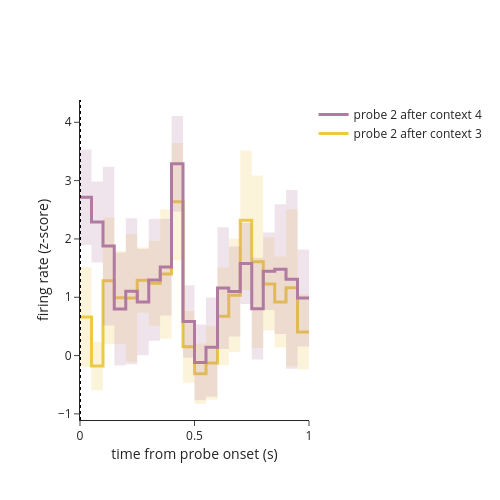

In [24]:
panelname = 'big_psth'
fig = plot_raw_pair(cellid, contexts, probe, raster_fs=20, colors=TENCOLOR,
                    pupil='big', simplify=True, part='probe')

if panelname in panels.keys():
    panels.pop(panelname)

panels[panelname].extend(fig['data'])

img_bytes = fig.to_image(format="png", width=500, height=500)
Image(img_bytes)

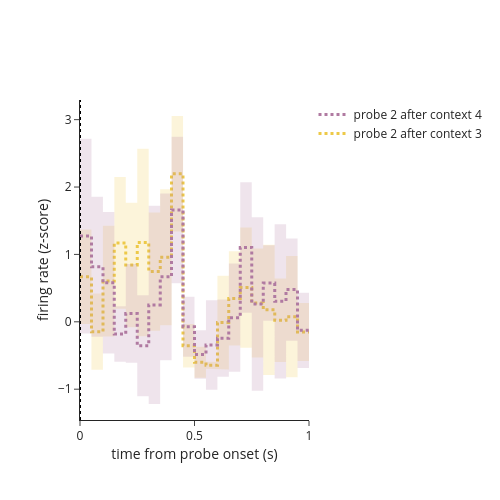

In [25]:
panelname = 'small_psth'
fig = plot_raw_pair(cellid, contexts, probe, raster_fs=20, colors=TENCOLOR,
                    pupil='small', simplify=True, part='probe')

fig.update_traces(line=dict(dash='dot'))

if panelname in panels.keys():
    panels.pop(panelname)

panels[panelname].extend(fig['data'])

img_bytes = fig.to_image(format="png", width=500, height=500)
Image(img_bytes)

________________________________________________________________________________
[Memory] Calling src.data.rasters.load_site_formated_raster...
load_site_formated_raster('ARM031a', part='probe', smoothing_window=50, raster_fs=20)


[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/ARM031a_540ec946ca8cf62782aba38237086b7831b7ad06.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Armillaria/ARM031/ARM031a10_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Armillaria/ARM031/ARM031a10_p_CPN.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Armillaria/ARM031/ARM031a11_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Armillaria/ARM031/ARM031a11_p_CPN.evp


________________________________________load_site_formated_raster - 3.7s, 0.1min


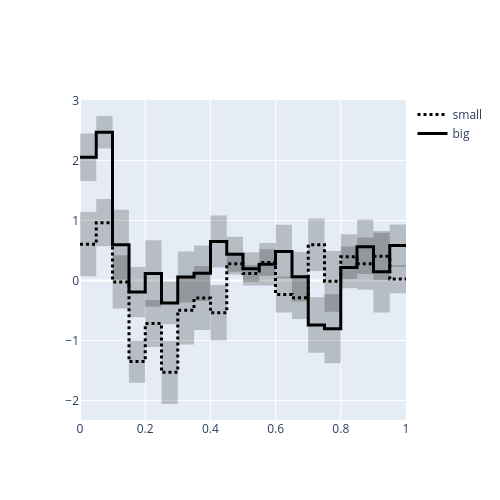

In [26]:
panelname = 'secon_ord_psth'
fig = plot_pupil_so_effects(cellid, contexts, probe, raster_fs=20)

if panelname in panels.keys():
    panels.pop(panelname)

panels[panelname].extend(fig['data'])

img_bytes = fig.to_image(format="png", width=500, height=500)
Image(img_bytes)

In [51]:
def define_subplots():
    fig = make_subplots(rows=2, cols=3, vertical_spacing=0.1, horizontal_spacing=0.05,
                        column_width=[1 / 3, 1 / 3, 1 / 3],
                        row_heights=[1 / 2, 1 / 2],
                        specs=[[{}, {}, {}],
                               [{}, {}, {}]])
    # figure size in inches at different PPIs
    ppi = 96  # www standard

    heigh = 6
    width = 8  # in inches
    _ = fig.update_layout(template='simple_white',
                          margin=dict(l=10, r=10, t=10, b=10),
                          width=round(ppi * width), height=round(ppi * heigh),

                          # first order scatter
                          xaxis=dict(),
                          yaxis=dict(scaleanchor='x'),

                          # second order scatter
                          xaxis2=dict(),
                          yaxis2=dict(scaleanchor='x2'),

                          # first vs second ord MI
                          xaxis3=dict(range=[-1,1]),
                          yaxis3=dict(range=[-1,1],
                                      scaleanchor='x3'),

                          # PSTH big pupil
                          xaxis4=dict(constrain='domain',
                                      title_text='time from probe onset (s)'
                                      ),
                          yaxis4=dict(autorange=True,
                              title_text='firing rate (z-score)'),

                          # PSTH small pupil
                          xaxis5=dict(constrain='domain',
                                      title_text='time from probe onset (s)'),
                          yaxis5=dict(matches='y4',
                                      showticklabels=False),

                          # delta PSTHs
                          xaxis6=dict(title_text='time from probe onset (s)'),
                          yaxis6=dict(scaleanchor='y4',
                                      autorange=True,
                                      title_text='delta firing rate (z-score)'),
                          showlegend=False,
                          font_size=10,
                          )
    fig.update_xaxes(title=dict(standoff=0))
    fig.update_yaxes(title=dict(standoff=0))

    # add letter annotations for subplots
    anotations = [
        ('a', 0, 1),
        ('b', 1 / 3, 1),
        ('c', 2 / 3, 1),
        ('d', 0, 1 / 2),
        ('e', 1 / 3, 1 / 2),
        ('f', 2 / 3, 1 / 2),
    ]

    for letter, x, y in anotations:
        fig.add_annotation(x=x, y=y,
                           text=f'<b>{letter}</b>', font_size=12,
                           xref='paper', yref='paper',
                           xanchor='center', yanchor='middle',
                           showarrow=False)

    return fig, round(ppi * width), round(ppi * heigh)


f, pw, ph = define_subplots()
f.print_grid()
# img_bytes = f.to_image(format="png", width=pw, height=ph)
# Image(img_bytes)

This is the format of your plot grid:
[ (1,1) x,y   ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



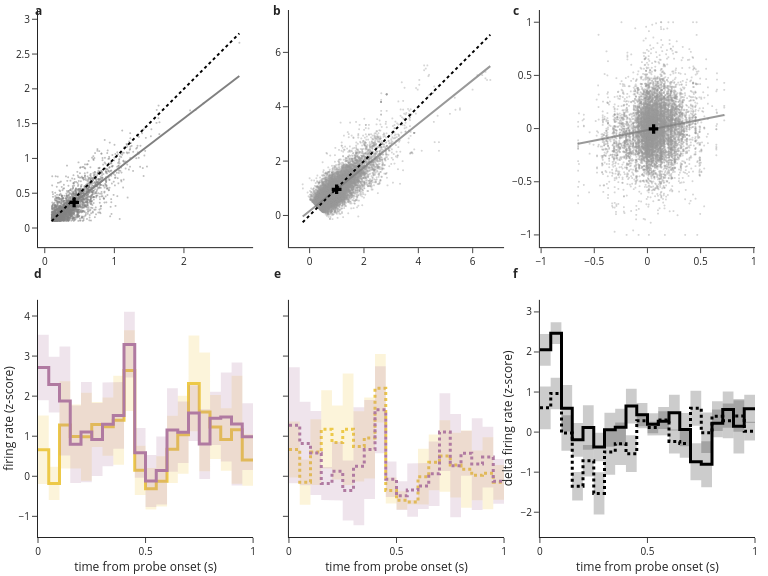

In [54]:
fig, pw, ph = define_subplots()

# top left
pan = panels['first_order_scatter']
fig.add_traces(pan, cols=[1] * len(pan), rows=[1] * len(pan))

# top center
pan = panels['second_order_scatte']
fig.add_traces(pan, cols=[2] * len(pan), rows=[1] * len(pan))

# top right
pan = panels['first_vs_second_order']
fig.add_traces(pan, cols=[3] * len(pan), rows=[1] * len(pan))

# bottom left
pan = panels['big_psth']
fig.add_traces(pan, cols=[1] * len(pan), rows=[2] * len(pan))

# bottom center
pan = panels['small_psth']
fig.add_traces(pan, cols=[2] * len(pan), rows=[2] * len(pan))

# bottom right
pan = panels['secon_ord_psth']
fig.add_traces(pan, cols=[3] * len(pan), rows=[2] * len(pan))

img_bytes = fig.to_image(format="png", width=pw, height=ph)
Image(img_bytes)

In [30]:
panels.keys()

dict_keys(['first_order_scatter', 'first_vs_second_order', 'second_order_scatte', 'big_psth', 'small_psth', 'secon_ord_psth'])